# Libraries & Helpers

In [88]:
# Libraries
import pandas as pd
import numpy as np
import gspread
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir("..")  
from src import config
from src import help_functions as hf

# Configs
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Data

In [89]:
# Import and quick check Training data 
googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
training_data, _ = hf.import_google_sheet(googleDrive_client=googleDrive_client, filename=config.DRIVE_TP_LOG_FILENAMES[0], sheet_index=0)

# "Clean" data
for col in training_data.columns:
    try:
        training_data[col] = training_data[col].apply(hf.safe_convert_to_numeric)
    except ValueError:
        pass 

# Date & Datetime
training_data["Date"] = pd.to_datetime(training_data[["Year", "Month", "Day"]]).dt.date
training_data["Datetime"] = pd.to_datetime(training_data[["Year", "Month", "Day"]])
training_data = training_data.sort_values(by="Date").reset_index(drop=True)

# About
print("Training data about:")
print("-----------------------------------------------------")
print("Todays date: {}".format(datetime.datetime.today().date()))
print("Date range: {} to {}".format(training_data["Date"].min(), training_data["Date"].max()))
print("Duplicated rows = {}".format(training_data[training_data.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=training_data["Date"].min(), end=training_data["Date"].max()).date if d not in training_data["Date"].values]))

print("\nDifferent activities and their counts:")
print("-------------------------------------")
activities_count_time = (
    training_data
    .groupby("Activity type")[["Duration [h]"]]
    .agg(
        count=("Duration [h]", "count"),
        total_duration=("Duration [h]", "sum")
        )
    .reset_index()
    .sort_values(by="total_duration", ascending=False)
    )

for _, row in activities_count_time.iterrows():
    print("{} ~> {:.2f} hours ({} act.)".format(row["Activity type"], row["total_duration"], row["count"]))

Training data about:
-----------------------------------------------------
Todays date: 2025-08-29
Date range: 2024-09-13 to 2025-08-28
Duplicated rows = 0
Missing dates = []

Different activities and their counts:
-------------------------------------
Trail Running ~> 285.94 hours (154 act.)
Road Biking ~> 78.77 hours (32 act.)
Running ~> 78.25 hours (76 act.)
Indoor Biking ~> 71.04 hours (51 act.)
Mountain Biking ~> 16.99 hours (9 act.)
Hiking ~> 15.35 hours (6 act.)
Road biking ~> 3.74 hours (2 act.)
Lap Swimming ~> 0.21 hours (1 act.)


In [90]:
# Import and quick check Daily data
googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
daily_data, _ = hf.import_google_sheet(googleDrive_client=googleDrive_client, filename=config.DRIVE_TP_LOG_FILENAMES[1], sheet_index=0)

# "Clean" data
for col in daily_data.columns:
    try:
        daily_data[col] = daily_data[col].apply(hf.safe_convert_to_numeric)
    except ValueError:
        pass 

# Date & Datetime
daily_data["Date"] = pd.to_datetime(daily_data[["Year", "Month", "Day"]]).dt.date
daily_data["Datetime"] = pd.to_datetime(daily_data[["Year", "Month", "Day"]])
daily_data = daily_data.sort_values(by="Date").reset_index(drop=True)

# About
print("Daily data about:")
print("-----------------------------------------------------")
print("Todays date: {}".format(datetime.datetime.today().date()))
print("Date range: {} to {}".format(daily_data["Date"].min(), daily_data["Date"].max()))
print("Duplicated rows = {}".format(daily_data[daily_data.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=daily_data["Date"].min(), end=daily_data["Date"].max()).date if d not in daily_data["Date"].values]))

Daily data about:
-----------------------------------------------------
Todays date: 2025-08-29
Date range: 2024-04-15 to 2025-08-28
Duplicated rows = 0
Missing dates = []


# Development

We have two goals:

1. **Recent Adjusted Relative Training Load (ARTL)**

Define a simple metric that shows where we are with our current training compared to what we've been doing in the recent past. The purpose is to see if we should reduce out trainings load — so that we don't overreach or risk injury, or increase increase it to match what what our body has been adapted to in recent past. Or just simple define where in the training cycle we are if we take larger picture into account. *How are we positined relative to recent training load overall?*

2. **Recent Load Relative Percentile (RLRP)**

Quantify how hard today's training was compared to what we are used to. In other words, show where this session fall within the distribution of our recent sessions — is it an average day, a light day, or a clear spike? This also helps guide tomorrow’s (or few next days) training choice, since we know whether today was relatively light, normal, or heavy.

Dataset:

- All activities, regardless if it was real training or not (including hiking, swimming, easy cycling etc.).
- Lets assume we only have one "real" workout per day and take total (sum) daily training load (one sample is one day). 

Let $TL_i$ be the training load of the day i.

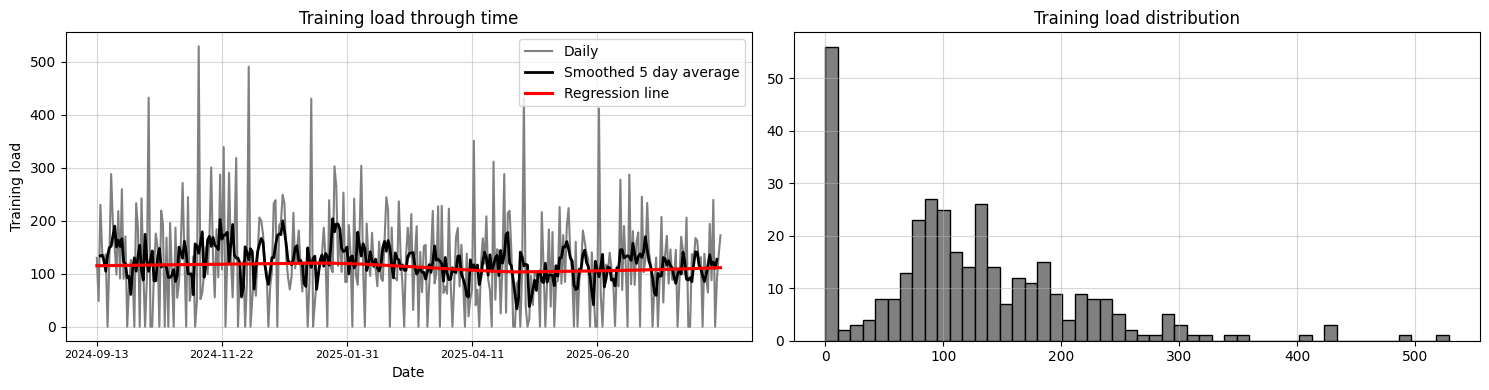

    Datetime  Training load                     Description
0 2025-04-12          350.6        Race Zalec Trail Running
1 2025-06-21          411.3       Race Tolmin Trail Running
2 2025-01-11          430.0      Race Nazarje Trail Running
3 2025-05-10          430.8       Race Idrija Trail Running
4 2024-10-12          431.9        Race Zalec Trail Running
5 2024-12-07          490.3      Race Velenje Trail Running
6 2024-11-09          528.6  Race Nova Gorica Trail Running


In [91]:
# Data:

rtl_data = (
    training_data
    .groupby("Datetime")
    .agg({
        "Training load": "sum",
        "Distance [km]": "sum",
        "Duration [h]": "sum",
        "Description": lambda x: " | ".join(x)  # concatenate descriptions
    })
    .reset_index()
    .assign(**{"Date index": lambda x: np.arange(x.shape[0])[::-1] + 1})
    # [["Date", "Training load"]]
)

# Exploratory data analysis - EDA
fig, ax = plt.subplots(1,2,figsize=(15, 4))
indices = np.arange(rtl_data.shape[0])

# Training load trough time
ax[0].set_title("Training load through time")
ax[0].plot(indices, rtl_data["Training load"], color="grey", label="Daily")
ax[0].plot(indices, rtl_data["Training load"].rolling(window=5, center=True).mean(), color="black", label="Smoothed 5 day average", linewidth=2)
sns.regplot(x=indices, y=rtl_data["Training load"], scatter=False, lowess=True, color="red", label="Regression line", ax=ax[0])
ax[0].legend()

ax[0].set_xticks(indices[::max(1, len(indices)//5)])  
ax[0].set_xticklabels(rtl_data["Datetime"].dt.strftime("%Y-%m-%d")[::max(1, len(indices)//5)], fontsize=8, rotation=0)
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Training load")

# Training load distribution
ax[1].set_title("Training load distribution")
ax[1].hist(rtl_data["Training load"], bins=50, color="grey", edgecolor="black")

for i in [0,1]:
    ax[i].grid(alpha=.5)
        
plt.tight_layout()
plt.show()

print(
    rtl_data
    .sort_values("Training load")
    [["Datetime", "Training load", "Description"]]
    .tail(7)
    .reset_index(drop=True)
)


### Recent Adjusted Relative Training Load (ARTL)

We want to define a history aware measure of current relative load. For that, we need to balance:
- Baseline (long term) adaptation - Load your body has been (succesfully) adapted to over a longer period, disregarding recent acute load
    - $TL_{\text{baseline},t}$
    - Baseline window: Lets take last 90 days (3 months) excluding last 14 days (2 weeks).
- Recent training pattern - Load our body is being exposed to in the recent window - reflects acute training load. 
    - $TL_{\text{recent},t}$
    - Recent weighted window: Lets take recent last 14 days (2 weeks).

In [92]:
# Define parameters
baseline_window_days = 90
recent_window_days = 14

In all endurance sports, days (trainings including races) are balanced between: 
- Easy days - recovery, aerobic base building, technique work (cca. 70% of all days)
- Hard days - tempo, threshold, VO2max (cca. 20% of all days)
- Long days - huge spike, extreme right tail. (cca. 10% of all days)

In [107]:
# Lets see how load looks like on easy day, hard days and long days
rtl_data["easy_hard_long_description"] = pd.Series(dtype="object")

# Eays days (No special description, duration < 1.5h)
easy_mask = (
    (rtl_data["Duration [h]"] < 1.5) &
    (rtl_data["Description"].str.contains("Running||Workout|Biking", case=False, na=False)) &
    ~(rtl_data["Description"].str.contains("Race", case=False, na=False))
)
rtl_data.loc[easy_mask, "easy_hard_long_description"] = "easy"

# Hard days (Special description, duration < 2h)
hard_mask = (
    (rtl_data["Duration [h]"] < 1.5) &
    ~(rtl_data["Description"].str.contains("Running|Biking|Workout", case=False, na=False))
)
rtl_data.loc[hard_mask, "easy_hard_long_description"] = "hard"

# Medium long days (No special description, duration 1.5h - 2h)
medium_long_mask = (
    (rtl_data["Duration [h]"] >= 1.5) & (rtl_data["Duration [h]"] <= 2.0) 
    #(rtl_data["Description"].str.contains("Running|Workout|Biking", case=False, na=False))
)
rtl_data.loc[medium_long_mask, "easy_hard_long_description"] = "medium long"

# Long days (No special description, duration >= 2h)
long_mask = (
    (rtl_data["Duration [h]"] > 2.0) 
    #(rtl_data["Description"].str.contains("Running|Workout|Biking", case=False, na=False))
)
rtl_data.loc[long_mask, "easy_hard_long_description"] = "hard"